In [35]:
import tensorflow as tf
import tensorflow.keras.models
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import datetime, os
import seaborn as sns 
import codecs, json

tf.keras.backend.set_floatx('float64') # float64 as default

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.1.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
x_1 = np.linspace(-1,1,256)  # 256 points between -1 and 1 [256x1]
x_2 = np.linspace(1,-1,256)  # 256 points between -1 and 1 [256x1]

X, Y = np.meshgrid(x_1,x_2) 

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [3]:
X_u_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None]))

# Domain bounds
lb = np.array([-1, -1])
ub = np.array([1, 1]) 

a_1 = 1
a_2 = 1

usol = np.sin(a_1 * np.pi * X) * np.sin(a_2 * np.pi * Y)

u = usol.flatten('F')[:,None]

# Training Data

In [4]:
def trainingdata(N_u,N_f,N_v):
    
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None]))
    leftedge_u = usol[:,0][:,None]
    
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,-1][:,None]))
    rightedge_u = usol[:,-1][:,None]
    
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None]))
    topedge_u = usol[0,:][:,None]
    
    bottomedge_x = np.hstack((X[-1,:][:,None], Y[-1,:][:,None]))
    bottomedge_u = usol[-1,:][:,None]
    
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  
     
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u+N_v, replace=False) 
    
    X_u_train = all_X_u_train[idx[0:N_u], :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx[0:N_u],:]      #choose corresponding u
    
    X_boundary_val = all_X_u_train[idx[N_u+1:N_u+N_v], :] #choose indices from  set 'idx' (x,t)
    u_boundary_val = all_u_train[idx[N_u+1:N_u+N_v],:]      #choose corresponding u
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f = lb + (ub-lb)*lhs(2,N_f+N_v) 
    X_f_train = np.vstack((X_f[0:N_f,:], X_u_train)) # append training points to collocation points 
    X_interior_val = X_f[N_f:N_f+N_v,:]
    
    return X_f_train, X_u_train, u_train, X_interior_val, X_boundary_val, u_boundary_val   


# PINN 

In [5]:
def generate_PINN(n,L):  

    #generate an array representing the network architecture
    layers = np.ones(1+L).astype(int)*n # 1 input layer + L hidden layers
    layers[0] = 2
    layers[-1] = 1

    #layers = [2, n1, n2, n3,........., n_L] #Network Configuration 

    PINN = tf.keras.Sequential()

    PINN.add(tf.keras.layers.InputLayer(input_shape=(layers[0],),name="input_layer", dtype = 'float64'))
    
    PINN.add(tf.keras.layers.Lambda(lambda X: 2*(X - lb)/(ub - lb) - 1)) 
    
    initializer = 'glorot_normal'     
    
    for l in range (len(layers)-2):

      # Xavier Initialization  
      PINN.add(tf.keras.layers.Dense(layers[l+1],kernel_initializer=initializer, bias_initializer='zeros',
                                  activation = tf.nn.tanh, name = "layer" + str(l+1), dtype = 'float64'))
        
    PINN.add(tf.keras.layers.Dense(layers[-1],kernel_initializer=initializer, bias_initializer='zeros',
                          activation = None, name = "output_layer" , dtype = 'float64'))    
        
    return PINN  

# *Loss Function*

The loss function consists of two parts:
1. **loss_BC**: MSE error of boundary losses
2. **loss_PDE**: MSE error of collocation points satisfying the PDE

**loss** = loss_BC + loss_PDE

In [6]:
def loss_BC(model, x, y):

    loss_u = tf.reduce_mean(tf.square(y-model(x)))
    return loss_u

def loss_PDE(model, g):
    
    k = 1    
        
    x_1_f = g[:,0:1]
    x_2_f = g[:,1:2]
    
    with tf.GradientTape(persistent=True) as tape:

        tape.watch(x_1_f)
        tape.watch(x_2_f)
        
        g = tf.stack([x_1_f[:,0], x_2_f[:,0]], axis=1)
        
        u = model(g)
        u_x_1 = tape.gradient(u,x_1_f)
        u_x_2 = tape.gradient(u,x_2_f)
    
    u_xx_1 = tape.gradient(u_x_1,x_1_f)
    u_xx_2 = tape.gradient(u_x_2,x_2_f)
    
    del tape
    
    q = -( (a_1*np.pi)**2 + (a_2*np.pi)**2 - k**2 ) * np.sin(a_1*np.pi*x_1_f) * np.sin(a_2*np.pi*x_2_f)
            
    f = u_xx_1 + u_xx_2 + k**2 * u - q #residual
    
    loss_f = tf.reduce_mean(tf.square(f))
    
    return loss_f

def loss(model,x,y,g):

    loss_u = loss_BC(model,x,y)
    loss_f = loss_PDE(model,g)

    loss = loss_u + loss_f
    
    return loss

def loss_split(model, x,y, g):

    loss_u = loss_BC(model,x,y)
    loss_f = loss_PDE(model,g)
    
    return loss_u,loss_f  

# *Function Factory*

A factory to create an optimization function and gradient as required by scipy.optimize

In [7]:
def function_factory(model, x, y, x_to_train_f):

  """ 
    # Args:
    #   model [in]: an instance of `tf.keras.Model` or its subclasses.
    #   loss [in]: a function with signature loss_value = loss(pred_y, true_y).
    #   x [in]: the input part of training data.
    #   y [in]: the output part of training data.

      Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters)
  """

  #converting the input into a tensor for Automatic diff
  g = tf.Variable(x_to_train_f, dtype = 'float64') 

  # obtain the shapes of all trainable parameters in the model
  shapes = tf.shape_n(model.trainable_variables)
  n_tensors = len(shapes)

  # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
  # prepare required information first
  count = 0
  idx = [] # stitch indices
  part = [] # partition indices

  for i, shape in enumerate(shapes):
    n = np.product(shape)
    idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
    part.extend([i]*n)
    count += n

  part = tf.constant(part)

  def assign_new_model_parameters(params_1d):
      """A function updating the model's parameters with a 1D tf.Tensor.

      Args:
          params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
      """
        
      params = tf.dynamic_partition(params_1d, part, n_tensors)
      for i, (shape, param) in enumerate(zip(shapes, params)):
          model.trainable_variables[i].assign(tf.reshape(param, shape))

  # now create a function that will be returned by this factory

  def f(params_1d):
    """A function that can be used by an optimizer

    This function is created by function_factory.

    Args:
      params_1d [in]: a 1D tf.Tensor.

    Returns:
        A scalar loss and the gradients w.r.t. the `params_1d`.
    """

    with tf.GradientTape() as tape:
      
      assign_new_model_parameters(params_1d) # update the parameters in the model

      loss_value = loss(model, x, y, g)      # calculate the loss

    # calculate gradients and convert to 1D tf.Tensor
    grads = tape.gradient(loss_value, model.trainable_variables)
    grads = tf.dynamic_stitch(idx, grads)

    return loss_value.numpy().astype(np.float64), grads.numpy().astype(np.float64)

  # store this information as variables so we can use them outside the scope
  f.iter = tf.Variable(0)
  f.idx = idx
  f.part = part
  f.shapes = shapes
  f.assign_new_model_parameters = assign_new_model_parameters
      
  return f

In [8]:
def metrics(networkparams):
    
    func.assign_new_model_parameters(networkparams)
    
    g = tf.Variable(X_f_train, dtype = 'float64')
    
    loss_value = loss(PINN, X_u_train, u_train, g)
    
    u_pred = PINN(X_u_test)
    
    error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
    
    h = tf.Variable(X_interior_val, dtype = 'float64')
        
    val_loss = loss(PINN,X_boundary_val,u_boundary_val,h)
    
    text_file = open("loss_helm.txt", "a")
    n = text_file.write(str(loss_value.numpy())+ " " + str(error_vec) + " " + str(val_loss.numpy()) + "\n" )
    text_file.close()

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

Training time: 0.59
      fun: 16.99285519211501
 hess_inv: <81x81 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.56294685, -0.31889699, -0.32500409, -1.04314187,  0.01547261,
       -0.64372665,  0.21533058,  0.23212742,  1.80867827, -0.65305659,
        0.5614953 ,  0.17601595, -0.05588797,  0.4774065 ,  0.05990354,
       -0.21053233,  0.38902491, -0.02194108,  0.19194896,  0.28166088,
       -0.18955909,  0.33441007, -0.02367432,  0.17353027,  0.26115945,
        0.0073657 , -0.21702252,  0.08449595,  0.25932458,  0.05162731,
        0.44396209,  0.11659596, -0.25983248, -1.64820557, -0.8381861 ,
        0.29439479,  0.03769069, -0.14197488, -1.00177078, -0.57540909,
       -0.0056925 ,  0.70782935, -0.05372664, -0.91010263, -0.27453521,
        0.02415718,  0.03228908, -0.14156554, -0.00472237, -0.36159543,
       -0.11334641, -0.16101084,  0.05559745,  0.01154048,  0.03591473,
        0.13261345,  0.20668578,  0.21634913, -0.01061363,  0.68159723,
        0.23509439

(-1.0, 1.0, -1.0, 1.0)

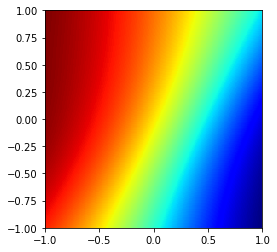

In [10]:
N_u = N_v = 400 #Total number of data points for 'u'
N_f = 100 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train, X_interior_val, X_boundary_val, u_boundary_val = trainingdata(N_u,N_f,N_v)

n = 5  # Neurons in each hidden layer
L = 4 # Number of hidden layers

# Neural Network
PINN = generate_PINN(n,L)

func = function_factory(PINN, X_u_train, u_train, X_f_train)

# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func.idx, PINN.trainable_variables)

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer

results = scipy.optimize.minimize(fun = func, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = None, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-5, 
                                            'maxfun':  50000, 
                                            'maxiter': 1,
                                            'iprint': 50,   #print update every 50 iterations
                                            'maxls': 50})


elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

# after training, the final optimized parameters are in results.position as vectors
# so we have to manually put them back to the model as matrices
func.assign_new_model_parameters(results.x)

print(results)

''' Model Accuracy ''' 
u_pred = PINN(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred,(256,256),order='F') 

#Plot and save image
plt.pcolor(x_1,x_2,u_pred, cmap = 'jet')
plt.axis('scaled')
# plt.savefig('Helmholtz_solution.png',dpi = 500)

In [19]:
PINN.trainable_weights

[<tf.Variable 'layer1_5/kernel:0' shape=(2, 5) dtype=float64, numpy=
 array([[ 0.83278097, -0.02537185, -0.17705621, -0.09073278,  0.37041969],
        [-1.08966514, -0.08666258, -0.31261289,  0.47575368,  0.45088036]])>,
 <tf.Variable 'layer1_5/bias:0' shape=(5,) dtype=float64, numpy=array([-0.14742087,  0.28228856,  0.09813373,  0.0137923 ,  0.4280245 ])>,
 <tf.Variable 'layer2_5/kernel:0' shape=(5, 5) dtype=float64, numpy=
 array([[ 2.46805766e-01, -5.83727361e-01,  1.27103829e-01,
          5.42076128e-01, -1.20530329e-05],
        [-5.17832571e-01, -2.71435821e-01, -3.83793727e-01,
          2.86267952e-01,  8.10710634e-01],
        [-3.60320106e-01,  7.06903378e-01, -1.04842587e-01,
         -4.07284453e-01, -6.51546448e-02],
        [ 6.60211446e-01,  2.59705350e-01, -3.75006462e-01,
         -4.88813690e-01,  3.31817541e-02],
        [-5.61938203e-01,  8.81982027e-01,  4.24499623e-01,
         -7.15375690e-02,  4.60949552e-01]])>,
 <tf.Variable 'layer2_5/bias:0' shape=(5,) dtyp

In [12]:
# print(results.hess_inv.todense())

In [13]:
# #check symmtericity tol #usually e-16
# print(np.linalg.norm(results.hess_inv.todense()-results.hess_inv.todense().T))

# #inverse of the hessian is symmetric, we can use eigvalsh
# eigenvalues = np.linalg.eigvalsh(results.hess_inv.todense())
# plt.plot(eigenvalues)

In [11]:
func.assign_new_model_parameters(results.x)
g = tf.Variable(X_f_train, dtype = 'float64')

shapes = tf.shape_n(PINN.trainable_variables) 
n_tensors = len(shapes)
count = 0
idx = [] # stitch indices
part = [] # partition indices

for i, shape in enumerate(shapes):
    n = np.product(shape)
    idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
    part.extend([i]*n)
    count += n
    
with tf.GradientTape(persistent=True) as tape_1:
    
    loss_u,loss_f = loss_split(PINN, X_u_train, u_train,g)

    grad_u = tape_1.gradient(loss_u, PINN.trainable_variables) 
    grad_f = tape_1.gradient(loss_f, PINN.trainable_variables)
    

In [15]:
# def flatten(params):
#     return tf.concat([tf.reshape(_params, [-1]) for _params in params], axis=0)

# g = tf.Variable(X_f_train, dtype = 'float64')

# parameters = flatten(PINN.trainable_variables)

# def test(v):
#     return flatten(tape_1.gradient(tf.math.multiply(grad_u, tf.stop_gradient(tf.Variable(tf.eye(P, P, dtype='float64'))), parameters))

# P = 5301

# with tf.GradientTape(persistent=True) as tape_1:
#     loss_u,loss_f = loss_split(PINN, X_u_train, u_train,g)
#     grad_u = flatten(tape_1.gradient(loss_u, PINN.trainable_variables))
#     print(grad_u)

# #     H_op = tf.map_fn(test, tf.eye(P, P, dtype='float64'), dtype='float64')
#     del tape_1

In [16]:
# def get_hessian(model):
    
#     g = tf.Variable(X_f_train, dtype = 'float64')
    
#     with tf.GradientTape(persistent=True) as tape:
#         loss_u,loss_f = loss_split(PINN, X_u_train, u_train,g)
#         grads_u = tape.gradient(loss_u, model.trainable_weights)
#         flattened_grads_u = tf.concat([tf.reshape(grad, [-1]) for grad in grads_u], axis=0)
#     hessians = tape.jacobian(flattened_grads_u, model.trainable_weights)
#     flattened_hessians = tf.concat([tf.reshape(hess, [hess.shape[0], -1]) for hess in hessians], 1)
#     return flattened_hessians

# print(np.linalg.norm(get_hessian(PINN).numpy()-get_hessian(PINN).numpy().T))

4.927336654569821e-15


In [36]:
#Writing gradients to 2 separate JSON files 
for i in range (L*2):

    temp = grad_f[i].numpy().tolist() # nested lists with same data, indices
    json.dump(temp, codecs.open("Gradients/gradients_f" + str(i) + ".json", 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=0)
    
    temp = grad_u[i].numpy().tolist() # nested lists with same data, indices
    json.dump(temp, codecs.open("Gradients/gradients_u" + str(i) + ".json", 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=0)
    

NameError: name 'grad_f' is not defined

In [52]:
f = {}
u = {}

#Reading gradients from JSON files and storing in a dict 
for i in range (L*2):

    obj_text = codecs.open("Gradients/gradients_f" + str(i) + ".json", 'r', encoding='utf-8').read()
    f['f'+ str(i)] = np.array(json.loads(obj_text))
    
    obj_text = codecs.open("Gradients/gradients_u" + str(i) + ".json", 'r', encoding='utf-8').read()
    u['u'+ str(i)] = np.array(json.loads(obj_text))

C:\Anaconda\envs\tf2\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Anaconda\envs\tf2\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Anaconda\envs\tf2\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Anaconda\envs\tf2\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Anaconda\envs\tf2\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Anaconda\envs\tf2\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning

<Figure size 432x288 with 0 Axes>

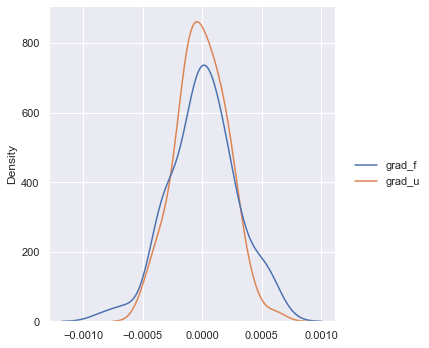

<Figure size 432x288 with 0 Axes>

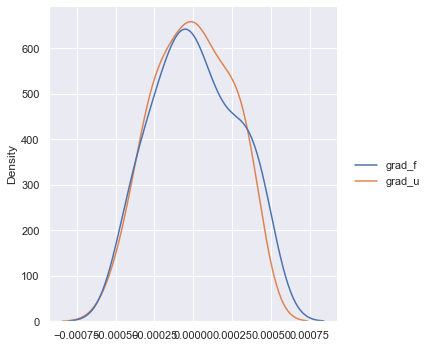

<Figure size 432x288 with 0 Axes>

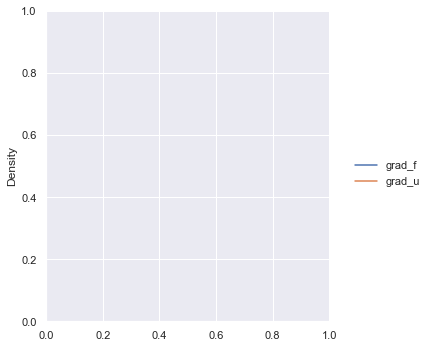

<Figure size 432x288 with 0 Axes>

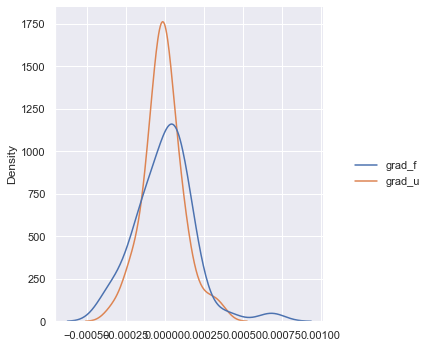

<Figure size 432x288 with 0 Axes>

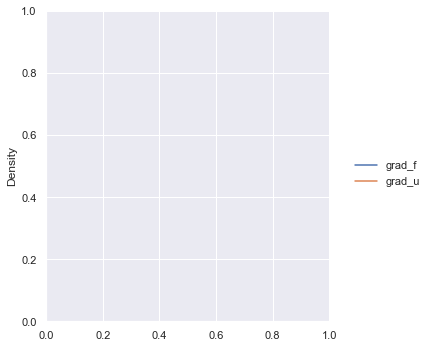

<Figure size 432x288 with 0 Axes>

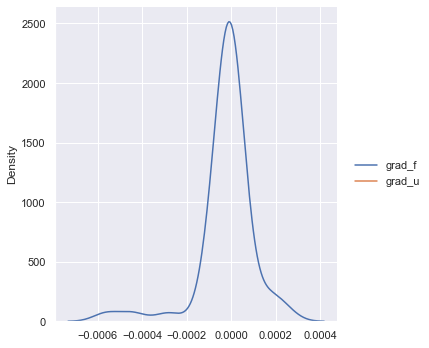

<Figure size 432x288 with 0 Axes>

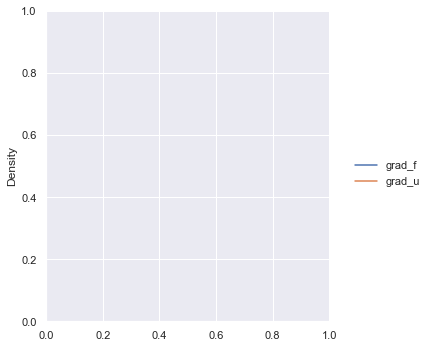

<Figure size 432x288 with 0 Axes>

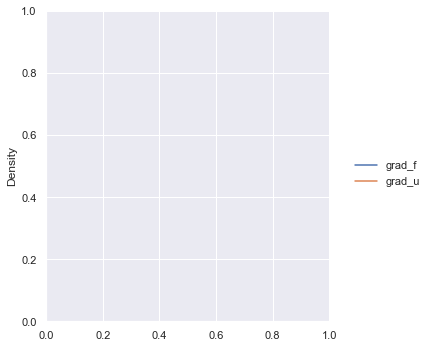

In [53]:
sns.set_theme()
for i in range (2*L):
    
    d = {}
    
    fig = plt.figure()
    
    d['grad_f'] = f['f'+ str(i)].flatten()
    d['grad_u'] = u['u'+ str(i)].flatten()
    fig = sns.displot(d,kind="kde").savefig("Gradients/output" + str(i) + ".png", dpi=500)
    
#     fig.savefig("Gradients/output" + str(i) + ".png", dpi=500)
